In [ ]:
import pandas as pd
import nltk
import sklearn
from sklearn.metrics import cohen_kappa_score

# Classifying *text* data

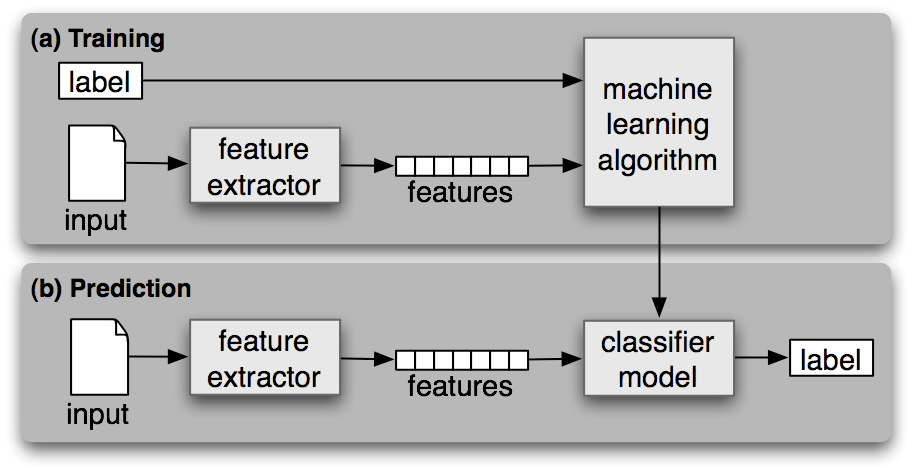

To this point, we have *not* been classifying text data. The question is: If we are working with text, what should the features be?

## The data set: SMS Spam Collection

Info is [here](https://github.com/trevordmiller/practice-python-data-science/tree/master/Python-Data-Science-and-Machine-Learning-Bootcamp/Machine%20Learning%20Sections/Natural-Language-Processing/smsspamcollection)

> The SMS Spam Collection v.1 (hereafter the corpus) is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. 

### First, we'll read it in, and take a look at it

In [ ]:
import csv, random
csvfile = open('corpora/spam_collection.csv')
dlist = list(csv.DictReader(csvfile, delimiter="\t"))

We'll create a pandas dataframe only because it will display the data more nicely.

In [ ]:
df = pd.DataFrame(dlist)
df.head()

### Next we have to tokenize it

Tokenizing this turns out to be a little of a pain. 
Since this was text posted online, people used all sorts of abbreviations, and contractions were important.

We'll use a special-purpose tokenizer I created for some twitter data. This uses some techniques that will learn about in a later week. Basically, it's the result of a lot of fiddling.

In [ ]:
def bruces_twitter_tokenizer(text):
    import re
    
    def is_contraction(the_text):
        contraction_patterns = re.compile(r"(?i)(.)('ll|'re|'ve|n't|'s|'m|'d)\b")
        return contraction_patterns.search(the_text)
    
    punctuation_class = r"([\.\-\/&\";:\(\)\?\!\]\[\{\}\*#])"
    
    # eliminate_urls
    text = re.sub(r"http\S*", "", text)
    
    # elimintate hashtags, user mentionds
    text = re.sub(r"#\S*", "", text)
    text = re.sub(r"@\S*", "", text)
    
    # Separate most punctuation at end of words

    text = re.sub(r"(\w)" + punctuation_class, r'\1 \2 ', text)
    
    # Separate most punctuation at start of words
    text = re.sub(punctuation_class + r"(\w)", r'\1 \2', text)
    
    # Separate punctuation from other punctuation
    text = re.sub(punctuation_class + punctuation_class, r'\1 \2 ', text)
    
    # Put spaces between + and = signs and digits. Also %s that follow a digit, $s that come before a digit
    text = re.sub(r"(\d)([+=%])", r'\1 \2 ', text)
    text = re.sub(r"([\$+=])(\d)", r'\1 \2', text)
    
    # Separate commas if they're followed by space.
    # (E.g., don't separate 2,500)
    text = re.sub(r"(,\s)", r' \1', text)
    
    #when we have two double quotes make it 1.
    #
    text = re.sub("\"\"", "\"", text)

    # Separate leading and trailing single and double quotes .
    text = re.sub(r"(\'\s)", r' \1', text)
    text = re.sub(r"(\s\')", r'\1 ', text)
    text = re.sub(r"(\"\s)", r' \1', text)
    text = re.sub(r"(\s\")", r'\1 ', text)
    text = re.sub(r"(^\")", r'\1 ', text)
    text = re.sub(r"(^\')", r'\1 ', text)
    text = re.sub(r"('\'$)", r' \1', text)
    text = re.sub(r"('\"$)", r' \1', text)

    #Separate parentheses where appropriate
    text = re.sub(r"(\)\s)", r' \1', text)
    text = re.sub(r"(\s\()", r'\1 ', text)

    # Separate periods that come before newline or end of string.
    text = re.sub('\. *(\n|$)', ' . ', text)
    
    # separate single quotes in the middle of words
    # text = re.sub(r"(\w)(\')(\w)", r'\1 \2 \3', text)
    
    # separate out 's at the end of words
    text = re.sub(r"(\w)(\'s)(\s)", r"\1 s ", text)
    split_text = text.split()
    
    return split_text


In [ ]:
tokenized_data_list = []
for n, row in enumerate(dlist):
    if row["text"] is None:
        print(n)
        break
    new_row = [bruces_twitter_tokenizer(row["text"].lower()), row["spam"]]
    tokenized_data_list.append(new_row)

In [ ]:
print(tokenized_data_list[0])

### Converting each text item to a featureset

There are many ways we could convert each response to a featureset. To start, we going to use a sort a "bag-of-words" representation. We are going to first create vocabulary consisting of some of the most common words. Then each feature will be the presence or absence of each item in our vocabulary. The order of words won't matter.

First we build a stop list:

In [ ]:
f = open("lists/stop-words_english_5_en.txt")
stop_list = f.read().split("\n")
stop_list += list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~’')
stop_list += list("abcdefghijklmnopqrstuvwxyz0123456789")
stop_list = set(stop_list)

Next we create a frequency distribution, ignoring words on the stop list

In [ ]:
import nltk
word_fdist = nltk.FreqDist() # the corpus frequences
for row in tokenized_data_list:
    for word in row[0]:
        if not word in stop_list:
            word_fdist[word] += 1

In [ ]:
word_fdist.most_common(10)

Our vocabulary will be the 100 most common words remaining.

In [ ]:
mc = word_fdist.most_common(100)
vocab = [w[0] for w in mc]
print(vocab)

Now we create the feature sets

In [ ]:
def word_feature_extractor(the_text, vocab):
    features = {}
    for word in vocab:
        features['contains({})'.format(word)] = (word in the_text)
    return features

In [ ]:
word_feature_extractor(tokenized_data_list[0][0], vocab)

In [ ]:
labeled_featuresets = []
for row in tokenized_data_list:
    new_lf = [word_feature_extractor(row[0], vocab), row[1]]
    labeled_featuresets.append(new_lf)

In [ ]:
print(labeled_featuresets[0])

In [ ]:
tdf = pd.DataFrame(labeled_featuresets)
tdf.head()

### Separate all of the labeled featuresets into a test set and a training set

Now that we have the labeled_featuresets, everything else is the same as what we did in the previous notebooks, that didn't use text data.

In [ ]:
test_size = int(.1 * len(labeled_featuresets))
test_size

In [ ]:
test_set = labeled_featuresets[:test_size]
train_set = labeled_featuresets[test_size:]

In [ ]:
spam_classifier = nltk.NaiveBayesClassifier.train(train_set)

In [ ]:
gold_list = [t[1] for t in test_set]
guess_list = [spam_classifier.classify(t[0]) for t in test_set]
cm = nltk.ConfusionMatrix(gold_list, guess_list)
print(cm)
print("accuracy = ", nltk.classify.accuracy(spam_classifier, test_set))
print("kappa = ", cohen_kappa_score(gold_list, guess_list))

In [ ]:
spam_classifier.show_most_informative_features()

### Try a decision tree

In [ ]:
spam_classifier = nltk.DecisionTreeClassifier.train(train_set)

In [ ]:
gold_list = [t[1] for t in test_set]
guess_list = [spam_classifier.classify(t[0]) for t in test_set]
cm = nltk.ConfusionMatrix(gold_list, guess_list)
print(cm)
print("accuracy = ", nltk.classify.accuracy(spam_classifier, test_set))
print("kappa = ", cohen_kappa_score(gold_list, guess_list))

In [ ]:
print(spam_classifier.pseudocode(depth=10))

In [ ]:
print(spam_classifier.pseudocode(depth=4))